In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import solve_ivp
from scipy import interpolate 
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date
import datetime
from myfunctions_multi_scale import *
%matplotlib inline

In [2]:
# Sensitivity analysis functions
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns

# sensitivity analysis is based on data from 2014 

In [3]:
# Import of I data
# irradiance data is based on meteorological data from: https://ims.data.gov.il/he/ims/6 
dFI = pd.read_csv('../data/ims_data_2014_umol_photons.csv',encoding= 'unicode_escape',header=None)
days = list(range(1,366))

In [4]:
I_plot = np.zeros(24*365)
light_hours = list(range(5,19)) #light hours defined according to longest days 
for day in days:
    for hour in light_hours:
        I_plot[(day - 1)*24 + hour] = float(dFI.iloc[day][hour-1])

annual_hours = list(range(1,(366-1)*24+1))
f0 = interpolate.interp1d(annual_hours, I_plot,kind = 'linear')

January 16
February 17
March 19
April 24
May 25
June 26
July 28
August 29
September 29.5
October 25
November 21
December 18


[Text(0, 0, '1 Jan'),
 Text(0, 0, '1 February'),
 Text(0, 0, '1 March'),
 Text(0, 0, '1 April'),
 Text(0, 0, '1 May'),
 Text(0, 0, '1 June'),
 Text(0, 0, '1 July'),
 Text(0, 0, '1 August'),
 Text(0, 0, '1 September'),
 Text(0, 0, '1 October'),
 Text(0, 0, '1 November'),
 Text(0, 0, '1 December')]

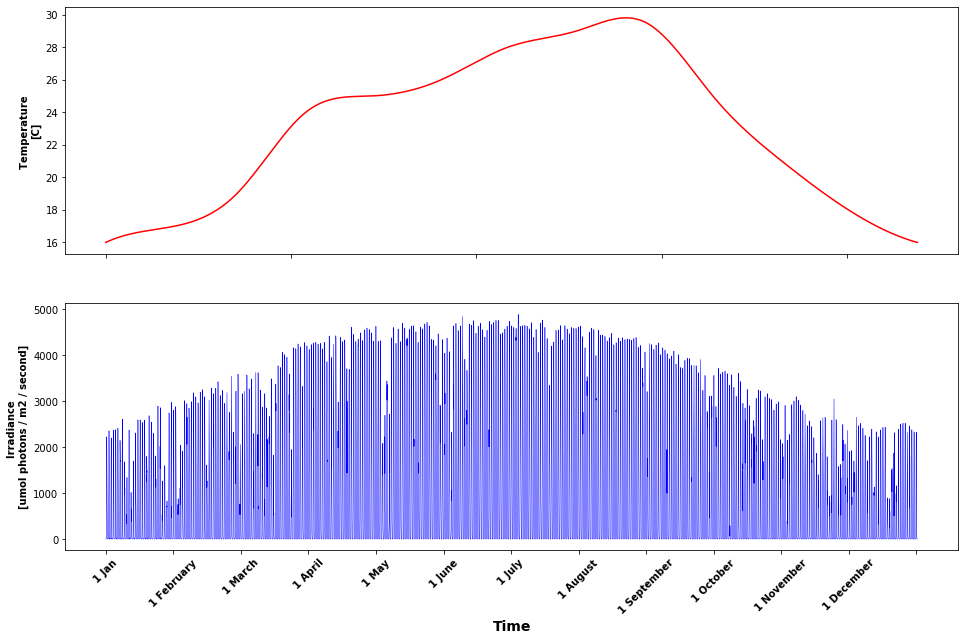

In [5]:
# T and light data

x1 = pd.ExcelFile('../data/input.xlsx')

dfT = x1.parse('T_multi-scale',header=None)
# Temperatures are water temperatures, taken from:
# Y. Suari, et al., Sandbar Breaches Control of the Biogeochemistry of a Micro-Estuary RIME-restoration of
# Israeli micro estuaries. Front. Mar. Sci. (2019) 

days_reduced,hours_reduced = [],[]
for i in range(1,13):
    day = datetime.datetime(2014, i, 1)
    days_reduced.append(int(day.strftime("%j")))

days_reduced.append(366)
for j in range(1,13):
    day = datetime.datetime(2014, j, 1)
    hours_reduced.append((int(day.strftime("%j"))-1)*24)
hours_reduced.append((366-1)*24)
T = []

# assigmment of parameters to values:
for key,val in zip(dfT.iloc[1:][0],dfT.iloc[1:][1]):
    exec(key + '=val')
    T.append(val)
    print(key,val)
T.append(T[0])
days = list(range(1,366))


# Interpolate T data (T_interp)

f1 = interpolate.interp1d(hours_reduced, T,kind = 'cubic')

T_interp = f1(annual_hours)


fig, ax = plt.subplots(2,1,figsize=(16,10))
xlabels = ['1 Jan', '1 February', '1 March', '1 April', '1 May', '1 June', '1 July', '1 August', '1 September', '1 October','1 November', '1 December']

ax[0].plot(annual_hours,T_interp, 'r-')
ax[1].plot(annual_hours,I_plot, 'b-', linewidth=0.5)

ax[1].set_xlabel('Time',fontsize=14, weight="bold")
ax[0].set_ylabel('Temperature \n[C]',fontsize=10, weight="bold")
ax[1].set_ylabel('Irradiance \n[umol photons / m2 / second]',fontsize=10, weight="bold")
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[1].set_xticks(annual_hours[0:len(annual_hours):int(len(annual_hours)/12-1)])
ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

In [6]:
I = np.zeros(24*365)
light_hours = list(range(5,19))
for day in days:
    for hour in light_hours:
        I[(day - 1)*24 + hour] = 0.43 * float(dFI.iloc[day][hour-1]) # 0.43 is PAR constant

annual_hours = list(range(1,(366-1)*24+1))
f0 = interpolate.interp1d(annual_hours, I,kind = 'linear')

In [7]:
df1 = x1.parse('Parameters_multi-scale',header=None)

# assigmment of parameters to values: 
for key,val in zip(df1.iloc[:][0],df1.iloc[:][1]):
    exec(key + '=val')
    print(key,val)

n_reactors = np.int(n_reactors)

umol_to_percent_DW 0.0014
n_days 14.0
Next0 500.0
Nint0 1.85
m0 0.15
S 30.0
Nintcrit 2.002
n_reactors 541.0
Qp 459.5833333333333
Qsea 7775.568181818181
Nsea 500.0
dilution 0.0
miu 0.027
Nintmax 4.2
Nintmin 0.7
KN 1.2
Ks 14.0
Vmax 60.0
Z 1.0
KI 20.0
K0 1.5
Ka 0.15
Topt 18.0
Tmin 5.0
Tmax 31.5
n 2.0
losses20 0.0016
teta 1.047
Sopt 18.0
Smin 0.0
Smax 45.0
Shigh 30.0
Slow 12.0


In [8]:
# sensitivity analysis definition: examined parameters and value ranges

problem = {
    'num_vars': 20,
    'names': ['Qp','µmax', 'Nintcrit','Nintmax','Nintmin','Ks','Vmax','KI','K0','Ka', 'n','Tmax','Topt','Tmin','λ20','Sopt','Smax','Smin','teta','dilution'],
    'bounds': [[300,600],
               [0.025, 0.035],
               [1.5, 3],
               [3.2,4.5],
               [0.5,0.7],
               [10,30],
               [50,250],
               [15, 150],
               [0.1,3],
               [0.01,0.2],
               [1, 6],
               [29, 32],
               [15, 20],
               [1,10],
               [0.001,0.005],
               [15,25],
               [40,50],
               [0,10],
               [0.9,1.2],
               [0,0.05]]
}
print(problem)

{'num_vars': 20, 'names': ['Qp', 'µmax', 'Nintcrit', 'Nintmax', 'Nintmin', 'Ks', 'Vmax', 'KI', 'K0', 'Ka', 'n', 'Tmax', 'Topt', 'Tmin', 'λ20', 'Sopt', 'Smax', 'Smin', 'teta', 'dilution'], 'bounds': [[300, 600], [0.025, 0.035], [1.5, 3], [3.2, 4.5], [0.5, 0.7], [10, 30], [50, 250], [15, 150], [0.1, 3], [0.01, 0.2], [1, 6], [29, 32], [15, 20], [1, 10], [0.001, 0.005], [15, 25], [40, 50], [0, 10], [0.9, 1.2], [0, 0.05]]}


In [9]:
n_reactors = 100

In [10]:
# number of examined values per parameter - 10
param_values = saltelli.sample(problem, 10)
print(param_values.shape)

(420, 20)


In [11]:
print(param_values)

[[3.65917969e+02 2.59667969e-02 2.27783203e+00 ... 3.44726562e+00
  1.19736328e+00 3.62792969e-02]
 [4.56738281e+02 2.59667969e-02 2.27783203e+00 ... 3.44726562e+00
  1.19736328e+00 3.62792969e-02]
 [3.65917969e+02 3.04980469e-02 2.27783203e+00 ... 3.44726562e+00
  1.19736328e+00 3.62792969e-02]
 ...
 [4.66113281e+02 2.83105469e-02 2.78466797e+00 ... 5.49804688e+00
  9.81738281e-01 2.55371094e-02]
 [4.66113281e+02 2.83105469e-02 2.78466797e+00 ... 5.49804688e+00
  1.07666016e+00 1.90917969e-02]
 [4.66113281e+02 2.83105469e-02 2.78466797e+00 ... 5.49804688e+00
  1.07666016e+00 2.55371094e-02]]


In [12]:
# 4 seasons - one cultivation period (14 days) per season

Y1 = np.zeros([param_values.shape[0]])
Y2 = np.zeros([param_values.shape[0]])
Y3 = np.zeros([param_values.shape[0]])
evaluate_model1 = []
evaluate_model2 = []
evaluate_model3 = []
x0 = n_reactors*[Nsea, Next0, Nint0, m0]
resolution = 1 # 1 out of how many cages is presented?
dilution = 0
weeks = [1, 9, 32, 46]
seasons = ['Winter', 'Spring', 'Summer','Automn']
k = 0
for j, X in enumerate(param_values):
    Qp = X[0]
    miu = X[1]
    Nintcrit = X[2]
    Nintmax = X[3]
    Nintmin = X[4]
    Ks = X[5]
    Vmax = X[6]
    KI = X[7]
    K0 = X[8]
    Ka = X[9]
    n = X[10]
    Tmax = X[11]
    Topt = X[12]
    Tmin = X[13]
    losses20 = X[14]
    Sopt = X[15]
    Smax = X[16]
    Smin = X[17]
    teta = X[18]
    dilution = X[19]
    
    Total_biomass = []
    Total_N = []
    NSEA, NEXT, NINT, M, Total_N, T = [],[],[],[],[],[]
    NSEA_F = []
        
    for week0 in weeks:
        t0 = 10 + 7 * 24 * (week0-1)
        t = list(range(t0,t0 + int(n_days*24)))
        times = list(range(t0,t0 + int(n_days*24)))
        args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
                teta,Sopt,Smin,Smax, Qp, Qsea, Nsea,f1,f0,dilution,n,umol_to_percent_DW)

        # solve the ODEs using the new syntax
        sol = solve_ivp(multi_N_f_un, [t[0], t[-1]], x0, args=args, t_eval = t)

        # take the solution of the state variables:
        M_farm, N_farm = [],[]
        for i in range(n_reactors):
            NSEA.append(sol.y[i*4,:])
            NEXT.append(sol.y[i*4+1,:])
            NINT.append(sol.y[i*4+2,:])
            M.append(sol.y[i*4+3,:])
            M_farm.append((M[-1][-1] - m0) * 1.785) # 1.785 is cage volume
            N_farm.append((M[-1][-1] * NINT[-1][-1] * 1.785 / 100)) # unit conversion to N removal
        Total_biomass.append(round(sum(M_farm),3))
        Total_N.append(round(sum(N_farm),4))
        NSEA_F.append(round(NSEA[-1][-1],3))
        T.append(sol.t)

        NSEA, NEXT, NINT, M, N_farm, T = [],[],[],[],[],[]
        x0 = n_reactors*[Nsea, Next0, Nint0, m0]
    evaluate_model1.append(np.sum(Total_biomass))
    evaluate_model2.append(np.sum(Total_N))
    evaluate_model3.append(np.mean(NSEA_F))                       
    Y1[j] = round(evaluate_model1[-1],4)
    Y2[j] = round(evaluate_model2[-1],4)
    Y3[j] = round(evaluate_model3[-1],4)
    print(k)
    k = k+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
print(min(Y1))
print(np.mean(Y1))
print(np.std(Y1))
print(np.median(Y1))
print(max(Y1))

-41.131
74.34541428571428
92.2725955967776
61.011
428.885


In [14]:
Si1 = sobol.analyze(problem, Y1,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Qp 0.000258 0.001169 0.000000 0.000001
µmax 0.093884 0.248937 0.023663 0.052944
Nintcrit 0.000001 0.000004 0.000000 0.000000
Nintmax 0.000290 0.000834 0.000001 0.000001
Nintmin 0.000326 0.000824 0.000000 0.000001
Ks 0.000165 0.000680 0.000000 0.000001
Vmax 0.000374 0.000966 0.000000 0.000001
KI 0.418641 0.482825 0.283582 0.565402
K0 -0.047379 0.062519 0.002831 0.008436
Ka 0.928803 0.663671 0.396448 0.206356
n -0.014740 0.061575 0.004615 0.009728
Tmax 0.044082 0.024912 0.000846 0.000656
Topt -0.009237 0.036188 0.000535 0.001580
Tmin -0.000289 0.006851 0.000040 0.000113
λ20 0.076707 0.464500 0.101153 0.302225
Sopt -0.020657 0.033915 0.000779 0.001940
Smax -0.008233 0.027361 0.000238 0.000614
Smin 0.000000 0.000000 0.000000 0.000000
teta -0.041658 0.068419 0.001937 0.002529
dilution -0.000023 0.000524 0.000000 0.000001

Parameter_1 Parameter_2 S2 S2_conf
Qp µmax -0.000360 0.001017
Qp Nintcrit -0.000336 0.001027
Qp Nintmax -0.000336 0.001028
Qp Nintmin -0.00

In [15]:
print(min(Y2))
print(np.mean(Y2))
print(np.std(Y2))
print(np.median(Y2))
print(max(Y2))

2.6576
6.456181904761905
3.3512411234327573
6.06605
19.0787


In [16]:
Si2 = sobol.analyze(problem, Y2,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Qp -0.001029 0.003752 0.000030 0.000084
µmax 0.108176 0.185103 0.020590 0.052478
Nintcrit 0.000000 0.000000 0.000000 0.000000
Nintmax 0.060971 0.092663 0.008821 0.024372
Nintmin 0.000708 0.002244 0.000005 0.000010
Ks 0.001819 0.009281 0.000182 0.000459
Vmax 0.002644 0.014038 0.000148 0.000547
KI 0.417455 0.258562 0.145802 0.220293
K0 -0.040585 0.046738 0.001533 0.003863
Ka 0.811719 0.580930 0.353676 0.234379
n -0.015412 0.052358 0.002408 0.005461
Tmax 0.042152 0.024744 0.000876 0.000709
Topt -0.005489 0.022827 0.000258 0.000696
Tmin -0.000112 0.007022 0.000049 0.000134
λ20 0.119873 0.455533 0.093360 0.168708
Sopt -0.019929 0.041585 0.000843 0.002051
Smax -0.006322 0.024835 0.000267 0.000761
Smin 0.000000 0.000000 0.000000 0.000000
teta -0.039770 0.062429 0.002375 0.003373
dilution 0.035549 0.104533 0.011346 0.024929

Parameter_1 Parameter_2 S2 S2_conf
Qp µmax -0.003199 0.005574
Qp Nintcrit -0.002295 0.005165
Qp Nintmax -0.003116 0.005492
Qp Nintmin -0.00

In [17]:
print(min(Y3))
print(np.mean(Y3))
print(np.std(Y3))
print(np.median(Y3))
print(max(Y3))

0.3175
76.15029357142858
112.85139027809637
27.04585
458.8598


In [18]:
Si3 = sobol.analyze(problem, Y3,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Qp 0.000665 0.002143 0.000001 0.000006
µmax 0.023429 0.057017 0.001073 0.001900
Nintcrit 0.000000 0.000000 0.000000 0.000000
Nintmax -0.003040 0.007755 0.000031 0.000189
Nintmin 0.000884 0.002280 0.000002 0.000003
Ks 0.000736 0.001689 0.000001 0.000006
Vmax 0.000988 0.002861 0.000002 0.000005
KI 0.021393 0.063879 0.001754 0.006658
K0 -0.004019 0.008377 0.000028 0.000057
Ka 0.076818 0.189105 0.008702 0.041901
n -0.000334 0.003992 0.000011 0.000068
Tmax 0.000825 0.006150 0.000014 0.000115
Topt 0.002530 0.005039 0.000009 0.000017
Tmin 0.000587 0.001119 0.000001 0.000002
λ20 0.001883 0.011661 0.000031 0.000086
Sopt -0.006250 0.011299 0.000054 0.000090
Smax -0.003025 0.005222 0.000011 0.000019
Smin 0.000000 0.000000 0.000000 0.000000
teta -0.000399 0.002790 0.000004 0.000018
dilution 1.360097 1.384800 0.965404 0.946094

Parameter_1 Parameter_2 S2 S2_conf
Qp µmax -0.002740 0.002728
Qp Nintcrit -0.002656 0.002581
Qp Nintmax -0.002665 0.002652
Qp Nintmin -0.0026

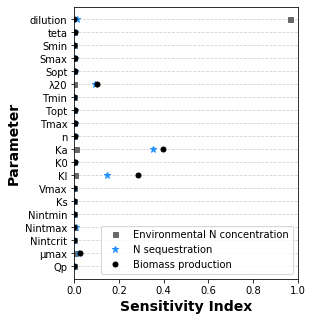

In [19]:
fig,ST2 = plt.subplots(1,1,sharex=True,figsize=(4,5))
ST2.plot(Si3['ST'],problem['names'],'s',markersize=5,color='dimgray')
ST2.plot(Si2['ST'],problem['names'],'*',markersize=7,color='dodgerblue')
ST2.plot(Si1['ST'],problem['names'],'.',markersize=10,color='black')


ST2.set_xlabel('Sensitivity Index',fontsize=14, weight="bold")
ST2.set_ylabel('Parameter',fontsize=14, weight="bold")
ST2.set_xlim([0, 1])
ST2.set_axisbelow(True)
ST2.yaxis.grid(color='lightgray', linestyle='dashed')
ST2.legend(['Environmental N concentration','N sequestration','Biomass production'])


name = 'fig3.png' 
fig.savefig(fname=name, dpi=600)